<a target="_blank" href="https://colab.research.google.com/github/sonder-art/neuroscience/blob/main/60_boostrap.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Execute the next cells to install the necessary libraries in `Colab`

In [1]:
import os

# Set the environment variable
os.environ['SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL'] = 'True'
# Verify if it's set correctly
print(os.environ.get('SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL'))


True


In [2]:
!pip install py-ddspls
#!pip install requests

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from itertools import cycle

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import py_ddspls

The next cell can only be executed if you are running the notebook locally, if you are in `Colab` skip it.

In [5]:
#from utils.brain import matrix_from_vector

In [6]:
import numpy as np
def upper_vectorization(A:np.array):
    triangle = np.triu(A, 1)
    vector = triangle[np.triu_indices(triangle.shape[0], 1)]

    return vector


def matrix_from_vector(v, n):
    matrix = np.zeros((n, n))
    i_upp = np.triu_indices(n, 1)
    matrix[i_upp] = v
    i_low = np.tril_indices(n, -1)
    matrix[i_low] = matrix.T[i_low]
    
    return matrix

## Subject demographics

In [7]:
demo_std_path = 'data/output/processed_demographics.csv'

Execute the cell below if you are on `Colab` if you are running this folder locally then there is no need for downloading the data.

In [8]:
demo_std_path = 'https://github.com/sonder-art/neuroscience/raw/main/data/output/processed_demographics.csv'


In [9]:
demo_std = pd.read_csv(demo_std_path)
print('demographics',demo_std.shape)

demographics (50, 11)


In [10]:
demo_names = demo_std.columns[1:]

## Subject brain vectors

Execute the cell below if you are on `Colab` if you are running this folder locally then there is no need for downloading the data.

In [11]:
import os
import requests
# Github Path
file_urls = ['https://github.com/sonder-art/neuroscience/raw/main/data/output/subject_brain_vectors.npy']
series_path = 'data/output/'

# Ensure the save folder exists
os.makedirs(series_path, exist_ok=True)

for url in file_urls:
    # Extract the file name
    file_name = url.split('/')[-1]
    
    # Full path for saving the file
    save_path = os.path.join(series_path, file_name)

    # Download and save the file
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download {file_name}")


Downloaded subject_brain_vectors.npy


In [12]:
stackedVecs = np.load('data/output/subject_brain_vectors.npy')
stackedVecs.shape

(50, 54946)

## Partial Leas Squares (Sparse)

In [13]:
X, Y = stackedVecs, demo_std.iloc[:,1:]
print(f'X: {X.shape}')
#print(X.columns.values)
print(f'y: {Y.shape}')

X: (50, 54946)
y: (50, 10)


In [14]:
n_components = 4

In [15]:
lambd = 0.0
Xs = {0:X}

model_0 = py_ddspls.model.ddspls(Xs, Y, lambd=lambd, R=n_components, mode="reg", verbose=True)

y_loads_zero = model_0.model.v
x_loads_zero = model_0.model.u[0]

In [16]:
lambdas = np.linspace(0.0, 0.35, 36)
lambdas

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35])

In [17]:
selected_lambdas = [0.0, 0.11, 0.11, 0.11, 0.11]

In [18]:
n_simulations = Y.shape[0]
n_components = 4

n_variables = Y.shape[1]

sample = np.arange(n_simulations)
sample

print(f'Simulations: {n_simulations}')
print(f'Varianles: {n_variables}')

Simulations: 50
Varianles: 10


In [19]:
bigx_loadings_outer = []
big_df_outer = []
bigx_loadings_sparse_outer = []
big_df_sparse_outer = []

referenceY_sparse = y_loads_zero
referenceX_sparse = x_loads_zero

for l in selected_lambdas:
    print(f'L={l}')
    bigx_loadings_inner = []
    big_df_inner = []
    bigx_loadings_sparse_inner = []
    big_df_sparse_inner = [] 

    simulation = []
    for s in range(n_simulations):
        # LOOCV SELECTION
        simulation.append('s'+str(s+1))
        loocv_sample = np.delete(sample, s)

        # LOOCV SAMPLING
        X_sample, Y_sample = X[loocv_sample, :], pd.DataFrame(Y.values[loocv_sample, :])

        Xsparse = {0:X_sample} 

        
        # FIT SPARSE PLS
        sparse_model = py_ddspls.model.ddspls(Xsparse, Y_sample, lambd=l, R=n_components, mode="reg", verbose=True)


        ### Y LOADINGS
        sim_loadings_Y = []
        sim_loadings_X = []

        sim_loadings_Y_sparse = []
        sim_loadings_X_sparse = []


        if s == 0:
            referenceY_sparse = sparse_model.model.v
            referenceX_sparce = sparse_model.model.u[0]

            for c in range(n_components):
                sim_loadings_Y_sparse.append(sparse_model.model.v[:,c])
                sim_loadings_X_sparse.append(sparse_model.model.u[0][:,c])

        else:
            for c in range(n_components):
                rY_sparse = np.corrcoef(referenceY_sparse[:,c], sparse_model.model.v[:,c])[0,1]
                rX_sparse = np.corrcoef(referenceX_sparse[:,c], sparse_model.model.u[0][:,c])[0,1]

                    
                ### SPARSE CORRELATIONS
                if (rY_sparse < -0.1):
                    sim_loadings_Y_sparse.append(-1*sparse_model.model.v[:,c]) ### -1

                else :
                    sim_loadings_Y_sparse.append(sparse_model.model.v[:,c])


                if (rX_sparse < -0.1):
                    sim_loadings_X_sparse.append(-1*sparse_model.model.u[0][:,c]) ### -1

                else :
                    sim_loadings_X_sparse.append(sparse_model.model.u[0][:,c])


        df = pd.DataFrame(sim_loadings_Y_sparse)
        
        df['simulation'] = 's'+str(s+1)
        df = df.melt('simulation', value_name='loading').drop('variable', 1)#.sort_values('simulation',ascending=True)
        df['lambda'] = l
        variables = ['v'+str(i+1) for i in range(n_variables)]
        df['variable'] = [i for i in variables for _ in range(n_components)]
        comps = cycle(['c'+str(i+1) for i in range(4)])
        df['component'] = [next(comps) for i in range(len(df))]
        big_df_sparse_inner.append(df)


        ### X LOADINGS
        bigx_loadings_sparse_inner.append(sim_loadings_X_sparse)
    
    dfs_sparse = pd.concat(big_df_sparse_inner)
    print(dfs_sparse.shape)
    
    big_df_sparse_outer.append(dfs_sparse)
print('SIMULATION DONE!')

L=0.0


TypeError: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
print(len(big_df_sparse_outer))
print(big_df_sparse_outer[0].shape)
big_df_sparse_outer[:2]

4
(2000, 5)


[   simulation   loading  lambda variable component
 0          s1 -0.305111    0.11       v1        c1
 1          s1 -0.088630    0.11       v1        c2
 2          s1 -0.254621    0.11       v1        c3
 3          s1  0.609625    0.11       v1        c4
 4          s1 -0.385322    0.11       v2        c1
 ..        ...       ...     ...      ...       ...
 35        s50 -0.002616    0.11       v9        c4
 36        s50  0.030281    0.11      v10        c1
 37        s50  0.470601    0.11      v10        c2
 38        s50 -0.353285    0.11      v10        c3
 39        s50  0.424842    0.11      v10        c4
 
 [2000 rows x 5 columns],
    simulation   loading  lambda variable component
 0          s1 -0.305111    0.11       v1        c1
 1          s1 -0.088630    0.11       v1        c2
 2          s1 -0.254621    0.11       v1        c3
 3          s1  0.609625    0.11       v1        c4
 4          s1 -0.385322    0.11       v2        c1
 ..        ...       ...     ...    

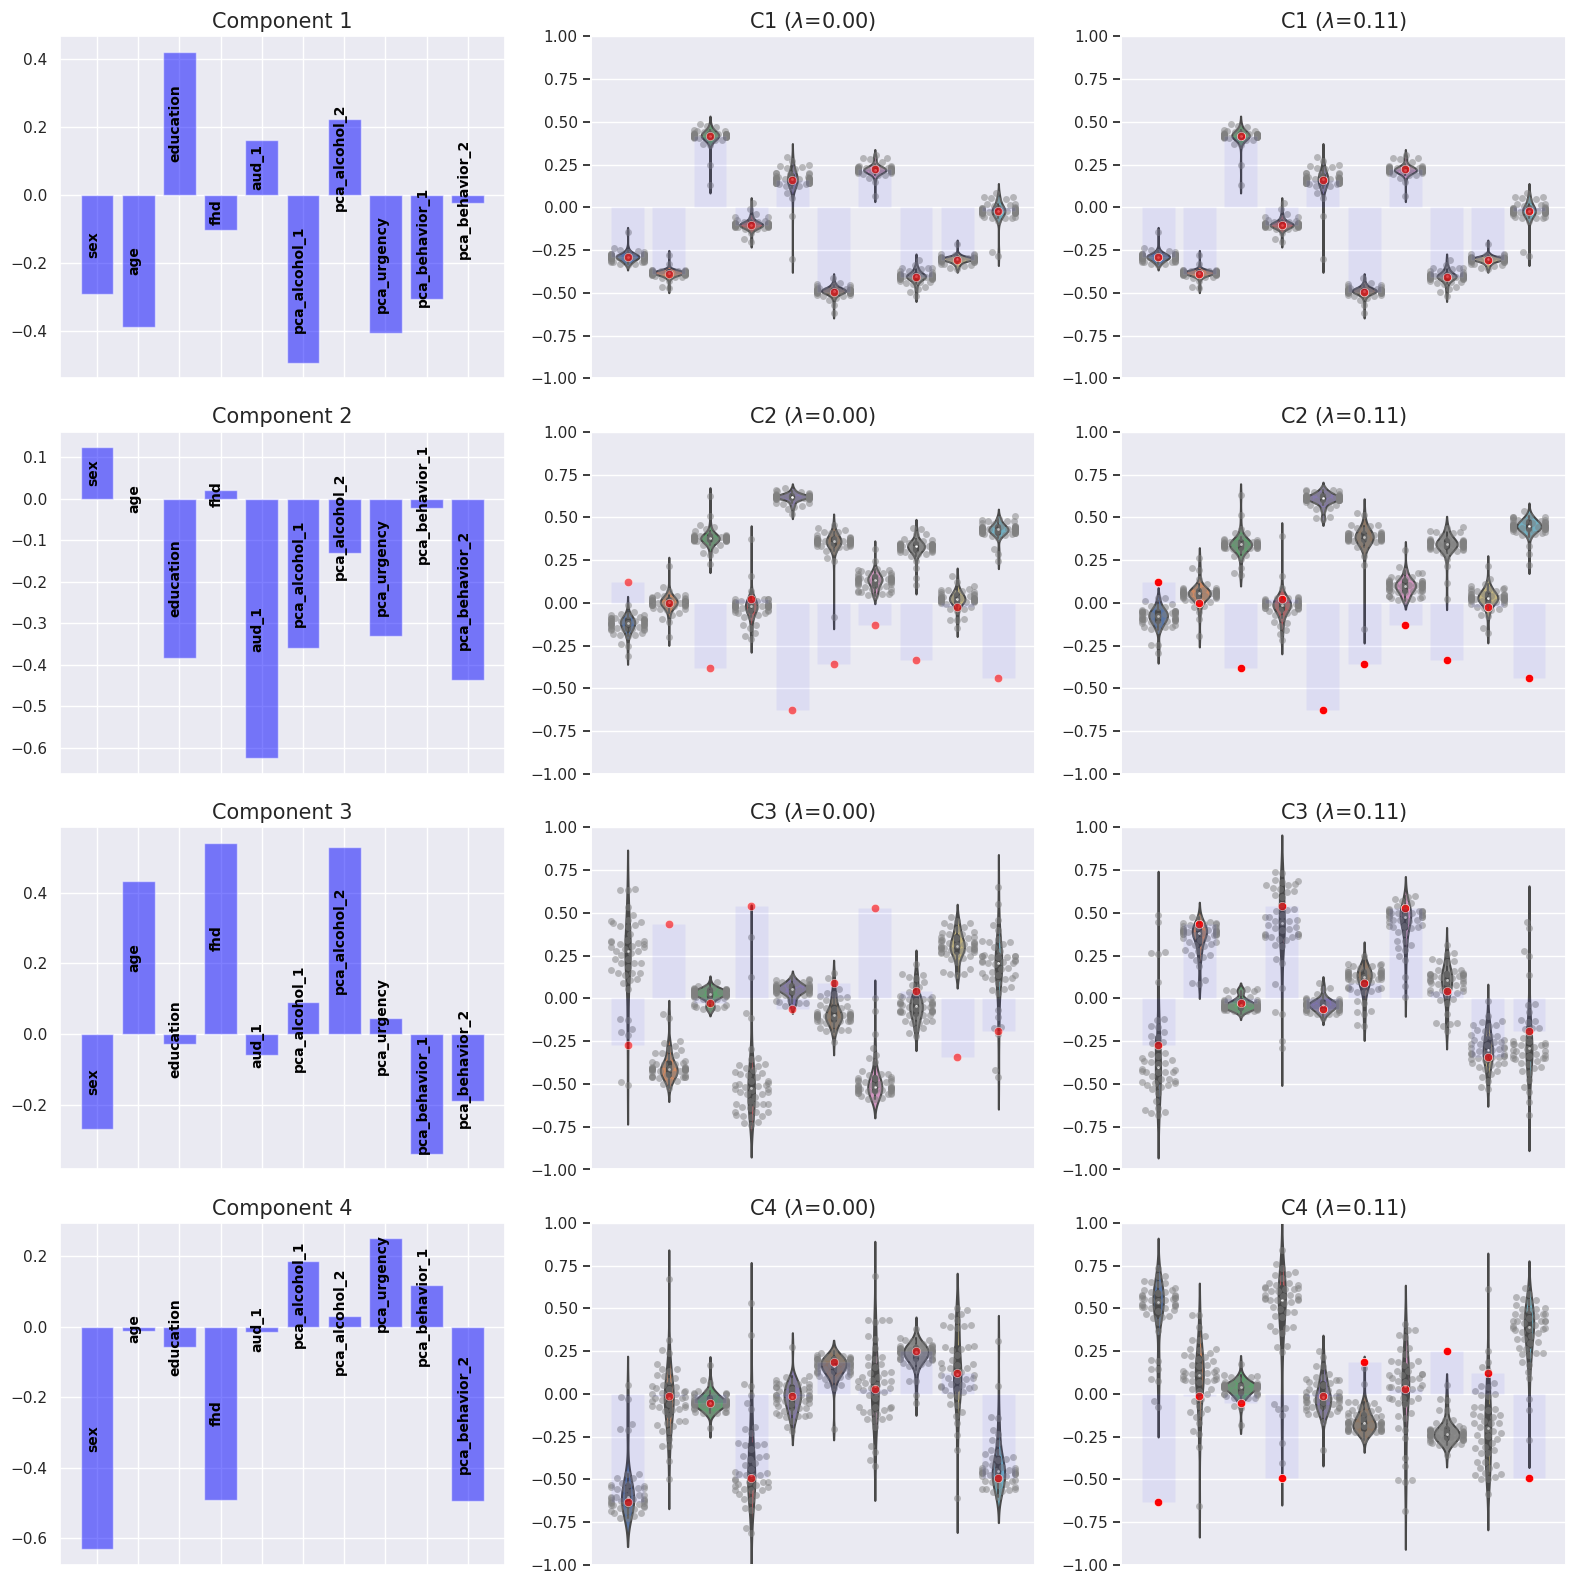

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(16, 16))

colors =['blue' for p in Y.columns]
names = [p for p in Y.columns]

ylow, yupp = -1, 1

for idx, comp in enumerate(['c1','c2','c3','c4']):
    
    ax = axes[idx][0]
    ax.set_title(f'Component {idx+1}', fontsize=15)
    ax.bar(Y.columns, y_loads_zero[:,idx], color=colors, alpha=0.5)
    for bar, variable in zip(ax.patches, names):
        ax.text(bar.get_x()+bar.get_width()/6, bar.get_y()+bar.get_height()/2, variable, color = 'black', weight='bold', ha = 'left', va = 'center', rotation=90, size=10)
    #ax.set_ylim(ylow, yupp)
    ax.set_xticklabels([])
    
    ax = axes[idx][1]
    ax.set_title(f'{str(comp).upper()} ($\lambda$={selected_lambdas[0]:.2f})', fontsize=15)
    sns.violinplot(x='variable', y='loading', data=big_df_sparse_outer[0][big_df_sparse_outer[0]['component']==comp], ax=ax)
    sns.swarmplot(x ='variable', y ='loading', data=big_df_sparse_outer[0][big_df_sparse_outer[0]['component']==comp] , color= "gray", alpha=0.5, ax=ax)
    ax.set_ylim(ylow, yupp)
    ax.set_xlabel('')
    ax.set_ylabel('')
    w = ax.get_xticklabels()
    ax2 = ax.twinx()
    ax2.bar(Y.columns, y_loads_zero[:,idx], color=colors, alpha=0.06)
    sns.scatterplot(y_loads_zero[:,idx] , color= "red", alpha=0.6, ax=ax2)
    ax2.set_ylim(ylow, yupp)
    plt.xticks([])
    plt.yticks([])
    
    ax = axes[idx][2]
    ax.set_title(f'{str(comp).upper()} ($\lambda$={selected_lambdas[idx+1]:.2f})', fontsize=15)
    sns.violinplot(x='variable', y='loading', data=big_df_sparse_outer[idx][big_df_sparse_outer[idx]['component']==comp], ax=ax)
    sns.swarmplot(x ='variable', y ='loading', data=big_df_sparse_outer[idx][big_df_sparse_outer[idx]['component']==comp] , color= "gray", alpha=0.5, ax=ax)
    sns.scatterplot(y_loads_zero[:,idx] , color= "red", ax=ax)
    ax.set_ylim(ylow, yupp)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax2 = ax.twinx()
    ax2.bar(Y.columns, y_loads_zero[:,idx], color=colors, alpha=0.06)
    sns.scatterplot(y_loads_zero[:,idx] , color= "red", alpha=0.6, ax=ax2)
    ax2.set_ylim(ylow, yupp)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()